# Bayesian neural network

First, we load the modules we need:

In [1]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

## Model

Decribe.

In [2]:
@dataclass
class BayesNN(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (2,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        X = data.X # [Batchsize, 28, 28]
        y = data.y # [Batchsize, 1]

        # Compute prior:
        log_prior_w = dx.Normal(0.0, jnp.exp(2.0 * theta["alpha"].squeeze())).log_prob(latent["w"].ravel()).sum()
        log_prior_v = dx.Normal(0.0, jnp.exp(2.0 * theta["beta"].squeeze())).log_prob(latent["v"].ravel()).sum()


        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        def _log_likelihood(images, labels):
            # Log-likelihood for set of images and labels, vectorized over particles.
            return vmap(lambda v, l : v[l])(_log_nn_vec(images), labels).sum()


        # Compute log-probability.
        return  (_log_likelihood(X, y) + log_prior_w + log_prior_v) / data.n # log p(y|x) + log p(x|theta) 
    

    def optimal_theta(self, latent_particles: Float[Array, "N D *"]) -> Float[Array, "Q *"]:
        """Optimal parameter for weight cloud w."""
        mom2 = (jax.vmap(_normsq)(latent_particles["w"])).mean()  # Second moment
        mom4 = (jax.vmap(_normsq)(latent_particles["v"])).mean()  # Fourth moment


        return {"alpha": jnp.log(mom2/(latent_particles["w"][0].size))/2, 
                "beta": jnp.log(mom4/(latent_particles["v"][0].size))/2}
        
    


def _normsq(x):
    # Squared Frobenius norm of x.
    v = x.reshape((x.size))
    return jnp.dot(v, v)

Next, we load and curate the dataset:

In [3]:
#@title Load, subsample, and normalize MNIST dataset.
import numpy as np

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

from coinem.dataset import Dataset

data = Dataset(jnp.array(itrain), jnp.array(ltrain).reshape(-1, 1))


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [124]:
# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 500  # Number of steps.
N = 10  # Number of particles.

key = jr.PRNGKey(42)

alpha = jnp.array(5.0)
beta = jnp.array(5.0)


# Initialize particle cloud by sampling prior:'
w_init = jnp.exp(alpha) * jr.normal(key, (N, 40, 28**2))  # Input layer weights.
v_init = jnp.exp(beta) * jr.normal(key, (N, 2, 40))  # Output layer weights.


theta_init = {"alpha": alpha, "beta": beta}
latent_init = {"w": w_init, "v": v_init}


from coinem.zoo import coin_svgd, pgd, adam_svgd, soul
from coinem.marginal_zoo import marginal_coin_svgd
model = BayesNN()

# x_coin, theta_coin = coin_svgd(model, data, latent_init, theta_init, K, alpha=100.0)
# x_pgd, theta_pgd = pgd(model, data, latent_init, theta_init, K, latent_step_size=1e-2, theta_step_size=1e-2)
# x_adam, theta_adam = adam_svgd(model, data, latent_init, theta_init, K, latent_step_size=1e-3, theta_step_size=1e-3)
# x_soul, theta_soul = soul(model, data, latent_init, theta_init, K, latent_step_size=1e-2, theta_step_size=1e-2)

# x_marginal_coin, theta_marginal_coin = marginal_coin_svgd(model, data, latent_init, theta_init, K, alpha=100.0)

In [162]:
from coinem.gradient_flow import stein_grad
from coinem.kernels import AutoRBF, RBF, MedianRBF

from jax.tree_util import Partial

score =  Partial(model.score_latent_particles, theta=theta_init, data=data)

def compute_grad(latent_particles):
    return stein_grad(latent_particles, score, MedianRBF())

compute_grad(latent_init)

jitted_compute_grad = jax.jit(compute_grad)

%timeit jitted_compute_grad(latent_init)

9.61 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [163]:
jitted_compute_grad(latent_init)

{'v': Array([[[ 2.20054500e-02,  1.00032594e-02,  1.01906089e-02,
           2.05220170e-02, -2.38540880e-02, -5.66700939e-03,
          -1.10315136e-03, -4.95029567e-03,  7.67022884e-03,
           6.13070326e-03,  1.03580868e-02, -8.62327591e-03,
           1.18087018e-02,  2.06993129e-02,  5.65577066e-03,
           4.19698982e-03,  1.24662099e-02,  1.66265927e-02,
           2.48536710e-02,  1.05903251e-04,  5.67755708e-03,
          -3.39191407e-03,  6.06649742e-03,  1.21273454e-02,
           1.68184172e-02,  2.36585643e-03, -8.33958667e-03,
          -4.65502078e-03, -1.38203492e-02, -7.98667036e-03,
           3.86732933e-03,  7.00649247e-03,  2.34732013e-02,
          -6.97560841e-03, -1.18511664e-02,  8.57800338e-03,
          -8.95242672e-03, -1.37802018e-02, -1.09987166e-02,
          -1.66121349e-02],
         [-2.20053922e-02, -1.00031551e-02, -1.01907011e-02,
          -2.05220841e-02,  2.38539986e-02,  5.66716166e-03,
           1.10308896e-03,  4.95023187e-03, -7.67024

In [89]:
# Copyright 2018 The JAX Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import warnings

import numpy as np

from jax import lax
import jax.numpy as jnp

from jax._src import dtypes
from jax._src.tree_util import tree_flatten, tree_unflatten
from jax._src.util import safe_zip, unzip2, HashablePartial

zip = safe_zip


def ravel(pytree):
  """Ravel (flatten) a pytree of arrays down to a 1D array.

  Args:
    pytree: a pytree of arrays and scalars to ravel.

  Returns:
    A pair where the first element is a 1D array representing the flattened and
    concatenated leaf values, with dtype determined by promoting the dtypes of
    leaf values, and the second element is a callable for unflattening a 1D
    vector of the same length back to a pytree of of the same structure as the
    input ``pytree``. If the input pytree is empty (i.e. has no leaves) then as
    a convention a 1D empty array of dtype float32 is returned in the first
    component of the output.

  For details on dtype promotion, see
  https://jax.readthedocs.io/en/latest/type_promotion.html.

  """
  leaves, _ = tree_flatten(pytree)
  return _ravel_list(leaves)

def unravel_pytree(treedef, unravel_list, flat):
  return tree_unflatten(treedef, unravel_list(flat))

def _ravel_list(lst):
  if not lst: return jnp.array([], jnp.float32), lambda _: []
  from_dtypes = tuple(dtypes.dtype(l) for l in lst)
  to_dtype = dtypes.result_type(*from_dtypes)

  if all(dt == to_dtype for dt in from_dtypes):
    # Skip any dtype conversion, resulting in a dtype-polymorphic `unravel`.
    # See https://github.com/google/jax/issues/7809.
    del from_dtypes, to_dtype
    raveled = jnp.concatenate([jnp.ravel(e) for e in lst])
    return raveled

  # When there is more than one distinct input dtype, we perform type
  # conversions and produce a dtype-specific unravel function.
  ravel = lambda e: jnp.ravel(lax.convert_element_type(e, to_dtype))
  return jnp.concatenate([ravel(e) for e in lst])

In [165]:
import functools
import jax.tree_util as jtu
from jax.flatten_util import ravel_pytree

from coinem.kernels import AutoMedianRBF

kern = AutoRBF()
log_prob = functools.partial(model.log_prob, theta=theta_init, data=data)

@jax.jit
def median_heuristic(particles):
    particle_array = vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x, y):
        return jnp.linalg.norm(jnp.atleast_1d(x - y))

    vmapped_distance = vmap(vmap(distance, (None, 0)), (0, None))
    A = vmapped_distance(particle_array, particle_array)  # Calculate distance matrix
    pairwise_distances = A[
        jnp.tril_indices(A.shape[0], k=-1)
    ]  # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    return (median**2) / jnp.log(particle_array.shape[0] + 1)

kern = AutoMedianRBF()

@functools.partial(jax.vmap, in_axes=[0, 0, None, None])
def phi_star_summand(x, y, n, h):
    score_x = jax.grad(log_prob)(x)
    kxy, dkxy = jax.value_and_grad(lambda x, y: kern.__call__(ravel(x)[0], ravel(y)[0], h), argnums=0)(x, y)
    return jax.tree_util.tree_map(lambda dpx, dkxy: ((kxy * dpx) + dkxy)/n, score_x, dkxy)

particles = latent_init

def compute_phi_star(particles):
    h = median_heuristic(particles)
    N = jtu.tree_flatten(particles)[0][0].shape[0]
    return phi_star_summand(particles, particles, N, h)

jit_compute_phi_star = jax.jit(compute_phi_star)

%timeit jit_compute_phi_star(particles)

%timeit compute_phi_star(particles)

7.45 ms ± 913 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.2 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [166]:
compute_phi_star(particles)

{'v': Array([[[ 2.44491138e-02,  1.14253238e-02,  1.19614657e-02,
           1.85478590e-02, -1.90992672e-02, -7.01025943e-04,
           9.82904807e-04, -8.46965238e-04,  8.83135665e-03,
           9.30744503e-03,  1.47004966e-02, -9.70008690e-03,
           1.03827016e-02,  2.01992933e-02,  4.92862565e-03,
           1.41857308e-03,  1.40828239e-02,  1.47550330e-02,
           2.27126889e-02, -1.31976046e-03,  3.82191432e-03,
          -8.92430544e-03,  2.71022017e-03,  1.10705392e-02,
           1.83555372e-02,  7.01786194e-04, -1.02112368e-02,
          -3.19278869e-03, -1.27138225e-02, -8.32459144e-03,
           3.33009171e-03,  8.69384315e-03,  2.28942782e-02,
          -1.05706174e-02, -1.00573581e-02,  1.16782263e-02,
          -9.23392922e-03, -1.19617209e-02, -7.30721187e-03,
          -1.38811497e-02],
         [-2.44491138e-02, -1.14253238e-02, -1.19614657e-02,
          -1.85478590e-02,  1.90992691e-02,  7.01025652e-04,
          -9.82904690e-04,  8.46965238e-04, -8.83135

In [152]:
import functools
from jax.flatten_util import ravel_pytree
from jax.tree_util import tree_map

def rbf_kernel(x, y, length_scale=10):
    arg = ravel_pytree(jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, x, y))[0]

    return jnp.exp(-(1 / length_scale) * arg.sum())

kernel = rbf_kernel
kernel = functools.partial(kernel, length_scale=1)

logdensity_fn = functools.partial(model.log_prob, theta=theta_init, data=data)

def phi_star_summand(particle, particle_):
    gradient = jax.grad(logdensity_fn)(particle)
    k, grad_k = jax.value_and_grad(kernel, argnums=0)(particle, particle_)
    return jax.tree_util.tree_map(lambda g, gk: (k * g) + gk, gradient, grad_k)

particles = latent_init

def compute_phi_star(particles):
    return jax.vmap(lambda p_: jax.tree_util.tree_map(lambda phi_star: phi_star.mean(axis=0), jax.vmap(lambda p: phi_star_summand(p, p_))(particles)))(particles)

%timeit compute_phi_star(particles)

jit_compute_phi_star = jax.jit(compute_phi_star)

%timeit jit_compute_phi_star(particles)

44.2 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.91 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
compute_phi_star(particles)

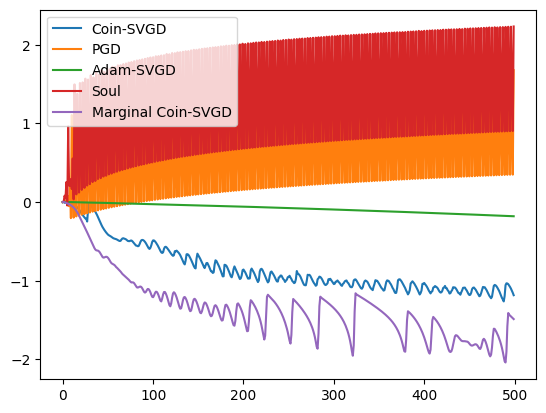

In [21]:
plt.plot(theta_coin["alpha"], label="Coin-SVGD")
plt.plot(theta_pgd["alpha"], label="PGD")
plt.plot(theta_adam["alpha"], label="Adam-SVGD")
plt.plot(theta_soul["alpha"], label="Soul")
plt.plot(theta_marginal_coin["alpha"], label="Marginal Coin-SVGD")
plt.legend()

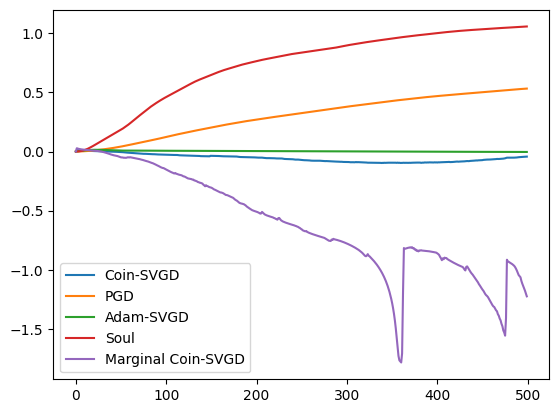

In [22]:
plt.plot(theta_coin["beta"], label="Coin-SVGD")
plt.plot(theta_pgd["beta"], label="PGD")
plt.plot(theta_adam["beta"], label="Adam-SVGD")
plt.plot(theta_soul["beta"], label="Soul")
plt.plot(theta_marginal_coin["beta"], label="Marginal Coin-SVGD")
plt.legend()

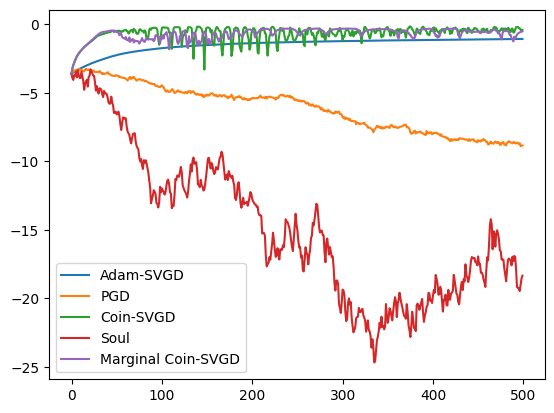

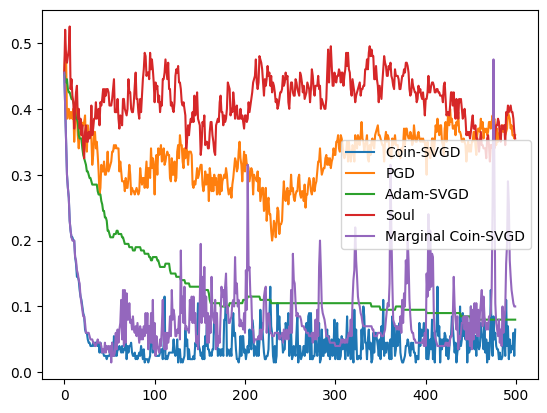

In [23]:
def log_pointwise_predrictive_density(model, latent_particles, images, labels):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return vmap(lambda v, l : v[l])(s, labels).mean()




def _predict(model, latent_particles, images):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten()))))  


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return jnp.argmax(s, axis=1)


def test_error(model, latent_particles, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels.squeeze() - _predict(model, latent_particles, images)).mean()

plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_marginal_coin), label="Marginal Coin-SVGD")

plt.legend()
plt.show()

plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_marginal_coin), label="Marginal Coin-SVGD")

plt.legend()
plt.show()